<a href="https://colab.research.google.com/github/andersonfloress/Trabajos_Est_Computacional/blob/main/Modelado_Agentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import random
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)  # Para reproducibilidad
random.seed(42)

print("✓ Librerías cargadas exitosamente")
print("✓ Configuración de visualización establecida")

✓ Librerías cargadas exitosamente
✓ Configuración de visualización establecida


In [ ]:
class ParametrosLuciernagas:
    def __init__(self):
        self.tamaño_espacio = 50
        self.num_luciernagas = 400
        self.radio_percepcion = 6
        self.umbral_sincronizacion = 0.1
        self.ritmo_base = 0.2
        self.max_iteraciones = 200

    def mostrar_parametros(self):
        print(f"Tamaño espacio: {self.tamaño_espacio}")
        print(f"Número luciérnagas: {self.num_luciernagas}")
        print(f"Radio percepción: {self.radio_percepcion}")
        print(f"Umbral sincronización: {self.umbral_sincronizacion}")
        print(f"Ritmo base: {self.ritmo_base}")
        print(f"Max iteraciones: {self.max_iteraciones}")

# Crear instancia y mostrar
params = ParametrosLuciernagas()
params.mostrar_parametros()

Tamaño espacio: 50
Número luciérnagas: 400
Radio percepción: 6
Umbral sincronización: 0.1
Ritmo base: 0.2
Max iteraciones: 200


In [ ]:
class ModeloLuci:
    def __init__(self, params):
        self.params = params
        self.grilla = None
        self.historial_sincronizacion = []
        self.historial_movimientos = []
        self.iteracion_actual = 0
        self.convergencia_alcanzada = False

    def inicializar_poblacion(self):
        N = self.params.tamaño_espacio
        self.grilla = np.zeros((N, N), dtype=float)

        total_celdas = N * N
        poblacion_total = min(self.params.num_luciernagas, total_celdas)

        # Elegir posiciones aleatorias para luciérnagas
        posiciones_disponibles = [(i, j) for i in range(N) for j in range(N)]
        random.shuffle(posiciones_disponibles)

        for idx in range(poblacion_total):
            i, j = posiciones_disponibles[idx]
            # Fase inicial aleatoria entre 0 y 1
            self.grilla[i, j] = random.random()

        print(f"✓ Población inicializada: {poblacion_total} luciérnagas con fases aleatorias")

    def obtener_vecinos(self, x, y):
        N = self.params.tamaño_espacio
        radio = self.params.radio_percepcion
        vecinos = []

        for dx in range(-radio, radio + 1):
            for dy in range(-radio, radio + 1):
                if dx == 0 and dy == 0:
                    continue
                nx, ny = x + dx, y + dy
                if 0 <= nx < N and 0 <= ny < N:
                    vecinos.append((nx, ny))
        return vecinos

    def actualizar_fase(self, x, y):
        fase = self.grilla[x, y]
        vecinos = self.obtener_vecinos(x, y)
        fases_vecinos = [self.grilla[i, j] for (i, j) in vecinos if self.grilla[i, j] > 0]

        # Emisión periódica: fase avanza con paso definido
        paso = self.params.ritmo_base
        fase += paso
        if fase > 1.0:
            fase = 0  # Parpadeo: fase vuelve a 0 (emisión de luz)

        # Ajuste de fase para sincronización:
        umbral_sincron = self.params.umbral_sincronizacion
        for fv in fases_vecinos:
            if 0 <= fv <= umbral_sincron:
                fase = min(fase, fv + umbral_sincron/2)

        self.grilla[x, y] = fase


    def esta_sincronizada(self, x, y):
        fase = self.grilla[x, y]
        vecinos = self.obtener_vecinos(x, y)
        fases_vecinos = [self.grilla[i, j] for (i, j) in vecinos if self.grilla[i, j] > 0]

        if not fases_vecinos:
            return True

        umbral_sincron = self.params.umbral_sincronizacion
        sincronizados = sum(1 for fv in fases_vecinos if abs(fv - fase) <= umbral_sincron)
        proporcion = sincronizados / len(fases_vecinos)

        return proporcion >= 0.5  # O usar otro umbral si quieres precisión fina

    def ejecutar_iteracion(self):
        """Ejecuta una iteración: actualización de fases y movimientos"""
        N = self.params.tamaño_espacio

        movimientos = 0
        # Primero actualizar fases de todas luciérnagas
        for i in range(N):
            for j in range(N):
                if self.grilla[i, j] > 0:
                    self.actualizar_fase(i, j)

        # Luego decidir movimientos para luciérnagas no sincronizadas
        posiciones = [(i, j) for i in range(N) for j in range(N) if self.grilla[i, j] > 0]
        random.shuffle(posiciones)

        celdas_vacias = [(i, j) for i in range(N) for j in range(N) if self.grilla[i, j] == 0]
        random.shuffle(celdas_vacias)

        for pos in posiciones:
            x, y = pos
            if not self.esta_sincronizada(x, y):
                if celdas_vacias:
                    nueva_pos = celdas_vacias.pop()
                    # Mover luciérnaga con su fase a la nueva posición
                    self.grilla[nueva_pos] = self.grilla[x, y]
                    self.grilla[x, y] = 0
                    celdas_vacias.append((x, y))
                    movimientos += 1

        # Detectar convergencia: por ejemplo, cuando proporción sincronizadas > 0.95 y sin movimientos
        sincronizadas = 0
        total = 0
        for i in range(N):
            for j in range(N):
                if self.grilla[i, j] > 0:
                    total += 1
                    if self.esta_sincronizada(i, j):
                        sincronizadas += 1
        proporcion_sync = sincronizadas / total if total > 0 else 0

        if proporcion_sync > 0.95 and movimientos == 0:
            self.convergencia_alcanzada = True

        return movimientos > 0

    def calcular_metricas(self):
        """Calcula proporción de luciérnagas sincronizadas y número de movimientos"""
        N = self.params.tamaño_espacio
        sincronizadas = 0
        total = 0

        for i in range(N):
            for j in range(N):
                if self.grilla[i, j] > 0:
                    total += 1
                    if self.esta_sincronizada(i, j):
                        sincronizadas += 1

        proporcion_sincronizadas = sincronizadas / total if total > 0 else 0
        return proporcion_sincronizadas

    def simular(self, mostrar_progreso=True):
        print("🚀 Iniciando simulación del Modelo de Luciérnagas...")

        self.inicializar_poblacion()

        sincronizacion_inicial = self.calcular_metricas()
        self.historial_sincronizacion.append(sincronizacion_inicial)
        self.historial_movimientos.append(0)

        if mostrar_progreso:
            print(f"Estado inicial - Proporción sincronizadas: {sincronizacion_inicial:.3f}")

        for iteracion in range(self.params.max_iteraciones):
            self.iteracion_actual = iteracion + 1

            hubo_movimientos = self.ejecutar_iteracion()

            proporcion_sync = self.calcular_metricas()
            self.historial_sincronizacion.append(proporcion_sync)
            self.historial_movimientos.append(hubo_movimientos)

            if mostrar_progreso and (iteracion + 1) % 10 == 0:
                print(f"Iteración {iteracion + 1:3d} - Proporción sincronizadas: {proporcion_sync:.3f}")

            if self.convergencia_alcanzada:
                print(f"\n✓ Convergencia alcanzada en iteración {iteracion + 1}")
                break

        print(f"\n📊 RESULTADOS FINALES:")
        print(f"   • Iteraciones ejecutadas: {self.iteracion_actual}")
        print(f"   • Proporción sincronizadas final: {self.historial_sincronizacion[-1]:.3f} ({self.historial_sincronizacion[-1]*100:.1f}%)")
        print(f"   • Movimientos realizados en última iteración: {self.historial_movimientos[-1]}")

print("✓ Clase ModeloLuci implementada")

✓ Clase ModeloLuci implementada


In [ ]:
def visualizar_grilla(modelo, titulo="Estado de la Simulación"):
    """Visualiza el estado actual de la grilla para luciérnagas (fase de parpadeo)"""
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Usamos un cmap tipo 'plasma' para mostrar la fase/estado de parpadeo
    im = ax.imshow(modelo.grilla, cmap='plasma', vmin=0, vmax=1)

    # Configuración
    ax.set_title(f"{titulo}\nIteración: {modelo.iteracion_actual}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Coordenada X")
    ax.set_ylabel("Coordenada Y")

    # Leyenda
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Fase / Intensidad de Luz (0=apagado, 1=encendido)')

    plt.tight_layout()
    plt.show()

def visualizar_evolucion(modelo):
    """Visualiza la evolución de sincronización y movimientos"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    iteraciones = range(len(modelo.historial_sincronizacion))

    # Gráfico de sincronización
    ax1.plot(iteraciones, modelo.historial_sincronizacion, 'o-', color='#f1c40f', linewidth=2, markersize=4)
    ax1.set_title('Evolución de la Sincronización', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Iteración')
    ax1.set_ylabel('Proporción Sincronizada')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    # Gráfico de movimientos
    ax2.plot(iteraciones, modelo.historial_movimientos, 'o-', color='#2980b9', linewidth=2, markersize=4)
    ax2.set_title('Evolución de Movimientos', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Iteración')
    ax2.set_ylabel('Proporción Moviéndose')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def comparar_estados(modelo):
    """Compara estado inicial y final para luciérnagas"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Mostrar estado final (fase de parpadeo)
    im = ax1.imshow(modelo.grilla, cmap='plasma', vmin=0, vmax=1)
    ax1.set_title('Estado Final de la Simulación (Fase de Parpadeo)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Coordenada X')
    ax1.set_ylabel('Coordenada Y')
    cbar = fig.colorbar(im, ax=ax1)
    cbar.set_label('Fase / Intensidad de Luz')

    # Estadísticas finales simples
    ax2.axis('off')
    sincronizacion_final = modelo.historial_sincronizacion[-1] if modelo.historial_sincronizacion else 0
    movimientos_final = modelo.historial_movimientos[-1] if modelo.historial_movimientos else 0

    texto = f"""
    ESTADÍSTICAS FINALES

    Parámetros:
    • Radio percepción: {modelo.params.radio_percepcion}
    • Umbral sincronización: {modelo.params.umbral_sincronizacion}
    • Tamaño del espacio: {modelo.params.tamaño_espacio}x{modelo.params.tamaño_espacio}
    • Número de luciérnagas: {modelo.params.num_luciernagas}  # Access through params
    • Ritmo base: {modelo.params.ritmo_base} # Added ritmo base for completeness

    Resultados:
    • Iteraciones: {modelo.iteracion_actual}
    • Sincronización final: {sincronizacion_final*100:.1f}%
    • Movimientos finales: {movimientos_final*100:.1f}%
    • Convergencia: {'Sí' if modelo.convergencia_alcanzada else 'No'}

    Interpretación:
    • Sincronización ≈ 1: Luciérnagas sincronizadas
    • Movimientos ≈ 0: Estabilidad en posiciones
    """

    ax2.text(0.05, 0.95, texto, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

print("✓ Funciones de visualización adaptadas para luciérnagas")

✓ Funciones de visualización adaptadas para luciérnagas


Tamaño espacio: 50
Número luciérnagas: 400
Radio percepción: 6
Umbral sincronización: 0.1
Ritmo base: 0.2
Max iteraciones: 200
✨ EXPERIMENTO 1: Simulación de Luciérnagas Sincronizadas
🚀 Iniciando simulación del Modelo de Luciérnagas...
✓ Población inicializada: 400 luciérnagas con fases aleatorias
Estado inicial - Proporción sincronizadas: 0.007

✓ Convergencia alcanzada en iteración 6

📊 RESULTADOS FINALES:
   • Iteraciones ejecutadas: 6
   • Proporción sincronizadas final: 1.000 (100.0%)
   • Movimientos realizados en última iteración: False

📊 Visualizando resultados...


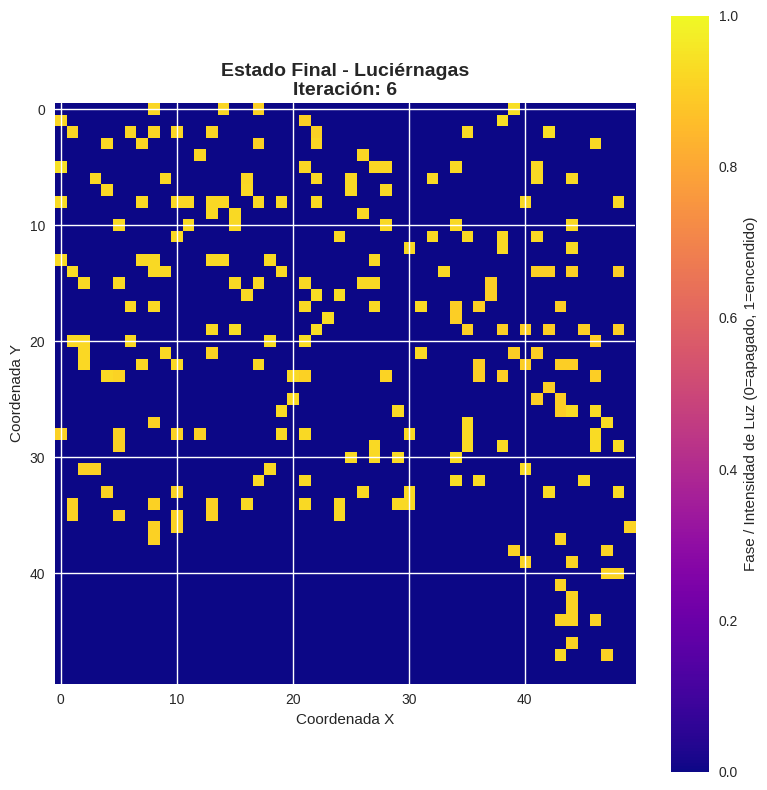

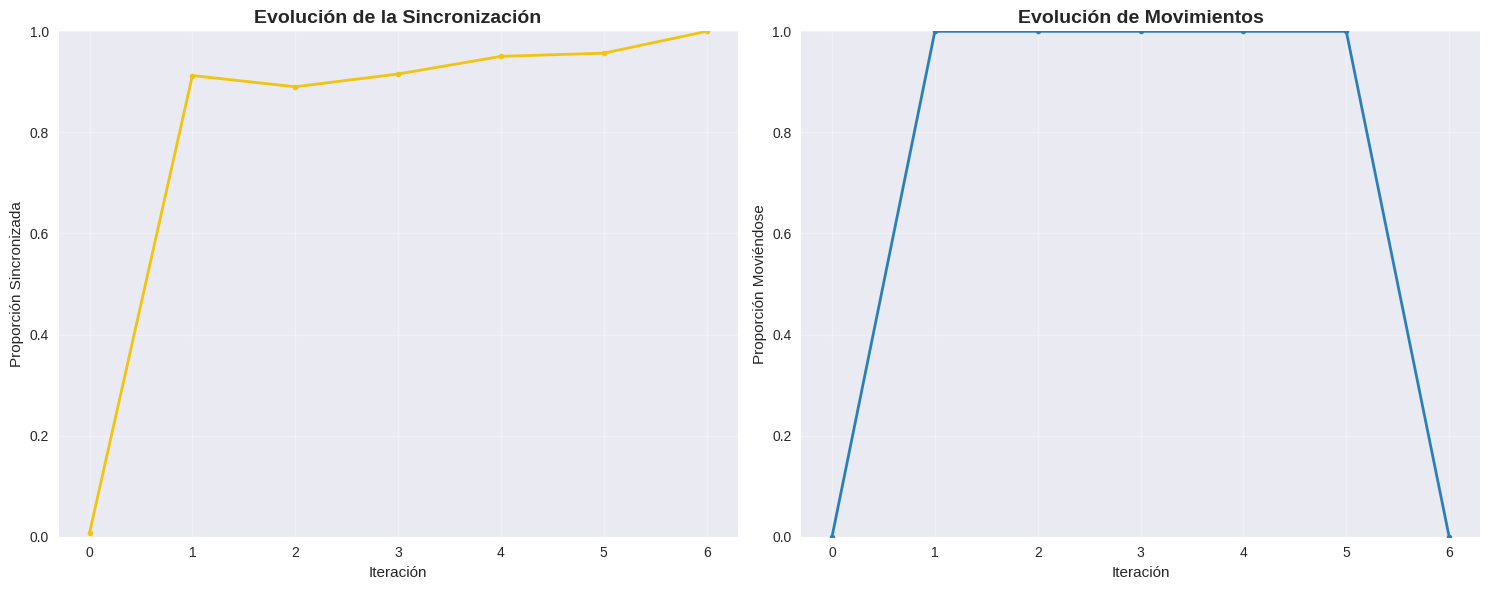

In [ ]:
# Crear instancia de parámetros
params = ParametrosLuciernagas()
params.mostrar_parametros()

# Crear y ejecutar modelo de luciérnagas con parámetros por defecto
print("✨ EXPERIMENTO 1: Simulación de Luciérnagas Sincronizadas")
print("=" * 50)

modelo_luci = ModeloLuci(params)
modelo_luci.simular()

print("\n📊 Visualizando resultados...")

# Visualizar grilla y evolución
visualizar_grilla(modelo_luci, titulo="Estado Final - Luciérnagas")
visualizar_evolucion(modelo_luci)

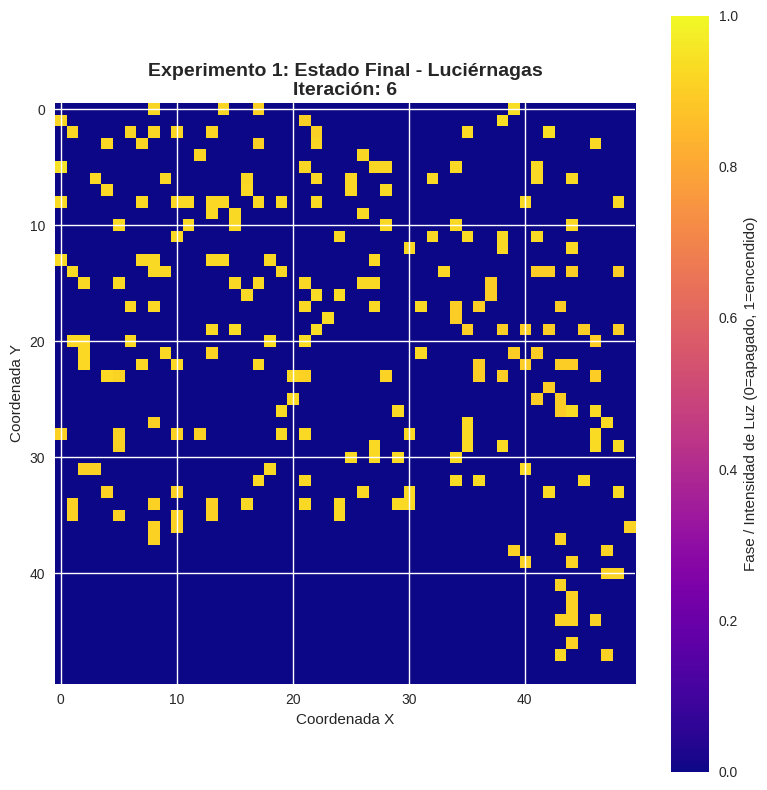

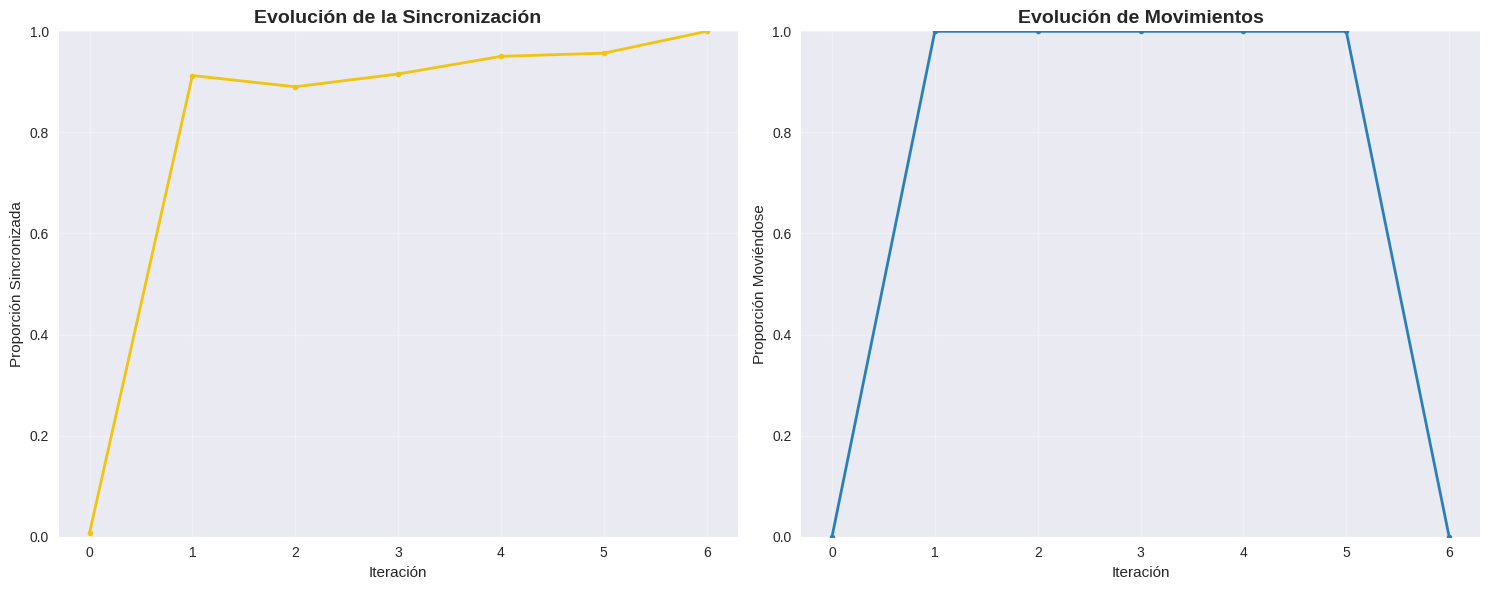

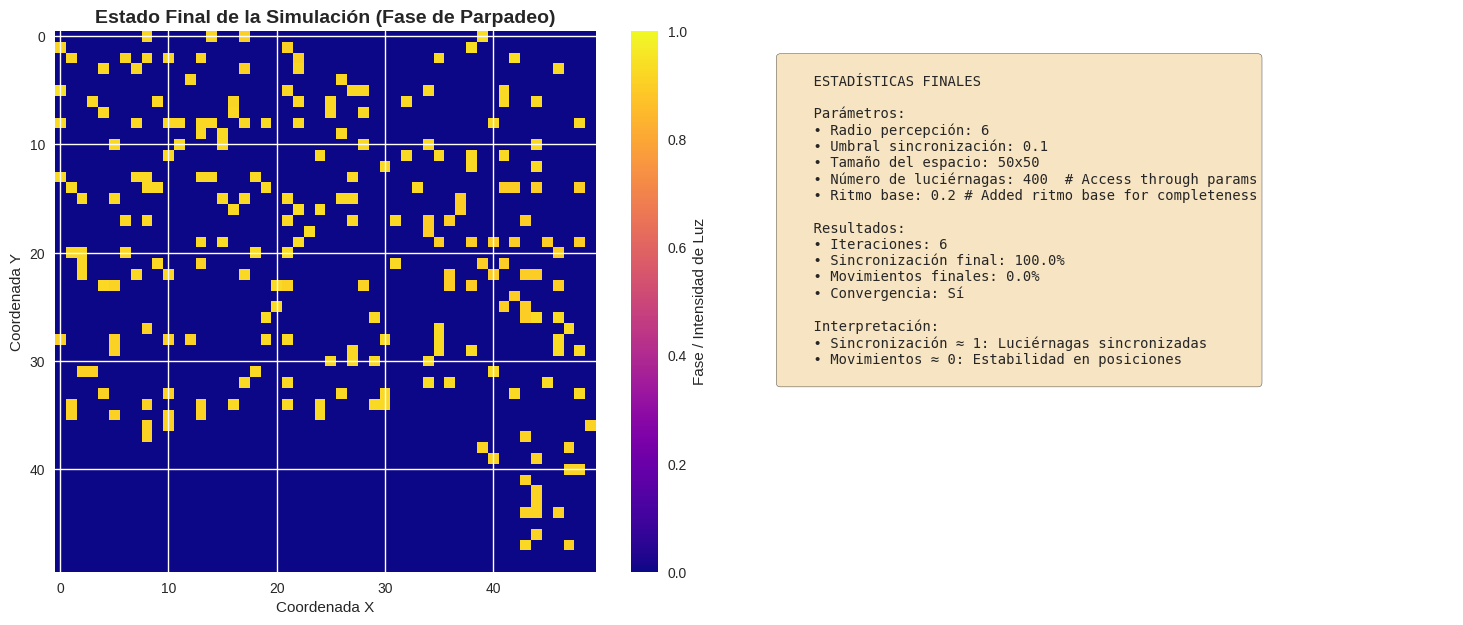

In [ ]:
# Visualizar estado final de las luciérnagas
visualizar_grilla(modelo_luci, "Experimento 1: Estado Final - Luciérnagas")

# Visualizar evolución de sincronización y movimientos
visualizar_evolucion(modelo_luci)

# Comparación completa de estados inicial y final (si guardas estado inicial)
comparar_estados(modelo_luci)

In [ ]:
print("🔬 EXPERIMENTO : Variación del Umbral de Sincronización")
print("=" * 60)

# Diferentes umbrales a probar
umbrales = [0.1, 0.3, 0.5, 0.7]
resultados_umbrales = []

for umbral in umbrales:
    print(f"\n🧪 Probando umbral de sincronía: {umbral*100:.0f}%")

    # Crear parámetros modificados
    params_temp = ParametrosLuciernagas()
    params_temp.umbral_sincronizacion = umbral
    params_temp.tamaño_grilla = 30  # Reducir tamaño para rapidez

    # Ejecutar simulación
    modelo_temp = ModeloLuci(params_temp)
    modelo_temp.simular(mostrar_progreso=False)

    # Guardar resultados
    resultado = {
        'umbral_sincronizacion': umbral,
        'iteraciones': modelo_temp.iteracion_actual,
        'proporcion_sincronizadas_final': modelo_temp.historial_sincronizacion[-1],
        'movimientos_final': modelo_temp.historial_movimientos[-1],
        'convergencia': modelo_temp.convergencia_alcanzada
    }
    resultados_umbrales.append(resultado)

    print(f"   ✓ Resultado: {resultado['proporcion_sincronizadas_final']*100:.1f}% sincronizadas, "
          f"movimientos: {resultado['movimientos_final']}")

# Crear DataFrame para análisis
df_umbrales = pd.DataFrame(resultados_umbrales)
print("\n📊 Resumen de resultados:")
print(df_umbrales.round(3))

🔬 EXPERIMENTO 2: Variación del Umbral de Sincronización

🧪 Probando umbral de sincronía: 10%
🚀 Iniciando simulación del Modelo de Luciérnagas...
✓ Población inicializada: 400 luciérnagas con fases aleatorias

✓ Convergencia alcanzada en iteración 6

📊 RESULTADOS FINALES:
   • Iteraciones ejecutadas: 6
   • Proporción sincronizadas final: 1.000 (100.0%)
   • Movimientos realizados en última iteración: False
   ✓ Resultado: 100.0% sincronizadas, movimientos: False

🧪 Probando umbral de sincronía: 30%
🚀 Iniciando simulación del Modelo de Luciérnagas...
✓ Población inicializada: 400 luciérnagas con fases aleatorias

✓ Convergencia alcanzada en iteración 1

📊 RESULTADOS FINALES:
   • Iteraciones ejecutadas: 1
   • Proporción sincronizadas final: 1.000 (100.0%)
   • Movimientos realizados en última iteración: False
   ✓ Resultado: 100.0% sincronizadas, movimientos: False

🧪 Probando umbral de sincronía: 50%
🚀 Iniciando simulación del Modelo de Luciérnagas...
✓ Población inicializada: 400 luc